<a href="https://colab.research.google.com/github/ritwiks9635/My_priject_file_5/blob/main/CAT_AND_DOG_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**classify images of cats and dogs by using transfer learning from a pre-trained network.**

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

***Import Moules***

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

***Data preprocessing***

load the dataset using tf.keras.utils.get_file. then split the dataset training and validation

In [ ]:
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path2zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin = url, extract = True)

68606236/68606236 [==============================] - 0s 0us/step


In [ ]:
Path = os.path.join(os.path.dirname(path2zip), 'cats_and_dogs_filtered')

In [ ]:
train_dir = os.path.join(Path, "train")
val_dir = os.path.join(Path, "validation")

In [ ]:
batch_size = 32
img_size = (160,160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
    batch_size = batch_size,
    image_size = img_size,
    shuffle = True)

Found 2000 files belonging to 2 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
    batch_size = batch_size,
    image_size = img_size,
    shuffle = True)

Found 1000 files belonging to 2 classes.


**Show the first nine images and labels from the training set**

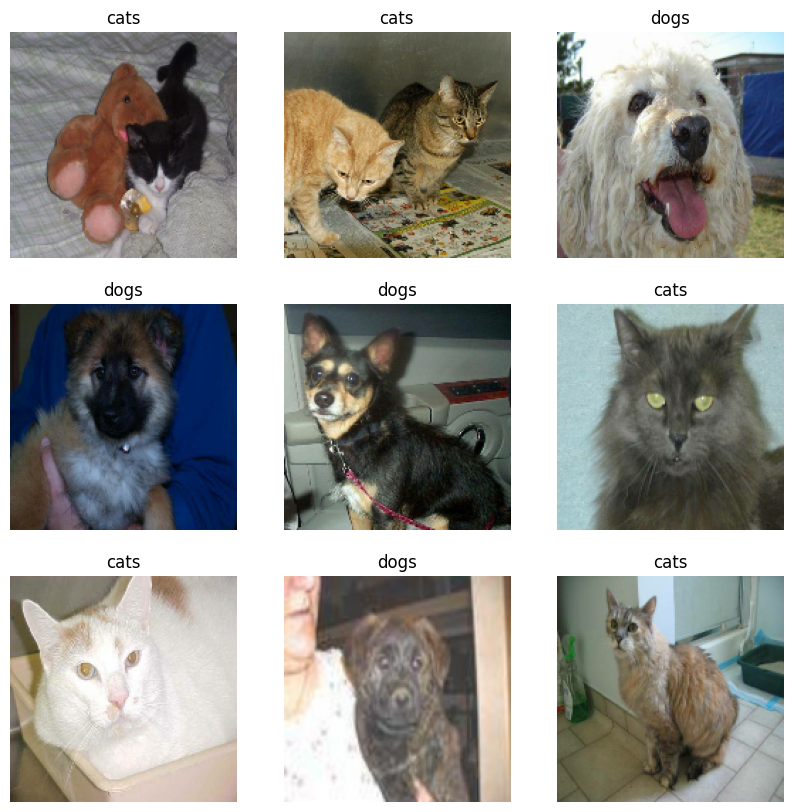

In [ ]:
classes = train_dataset.class_names
plt.figure(figsize=(10,10))
for imgs, labels in train_dataset.take(1):
  #print(labels)
  for x in range(9):
    plt.subplot(3,3,x+1)
    plt.imshow(imgs[x].numpy().astype("uint8"))
    plt.title(classes[labels[x]])
    plt.axis("off")
plt.show()

**As the original dataset doesn't contain a test set, you will create one.**

how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)

In [ ]:
len(val_dataset)

26

**Configure the dataset for performance**

In [ ]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = autotune)
val_dataset = val_dataset.prefetch(buffer_size = autotune)
test_dataset = test_dataset.prefetch(buffer_size = autotune)

**Use data augmentation**

When you don't have a large image dataset, it's a good to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)])

Show some Data Augmentation image

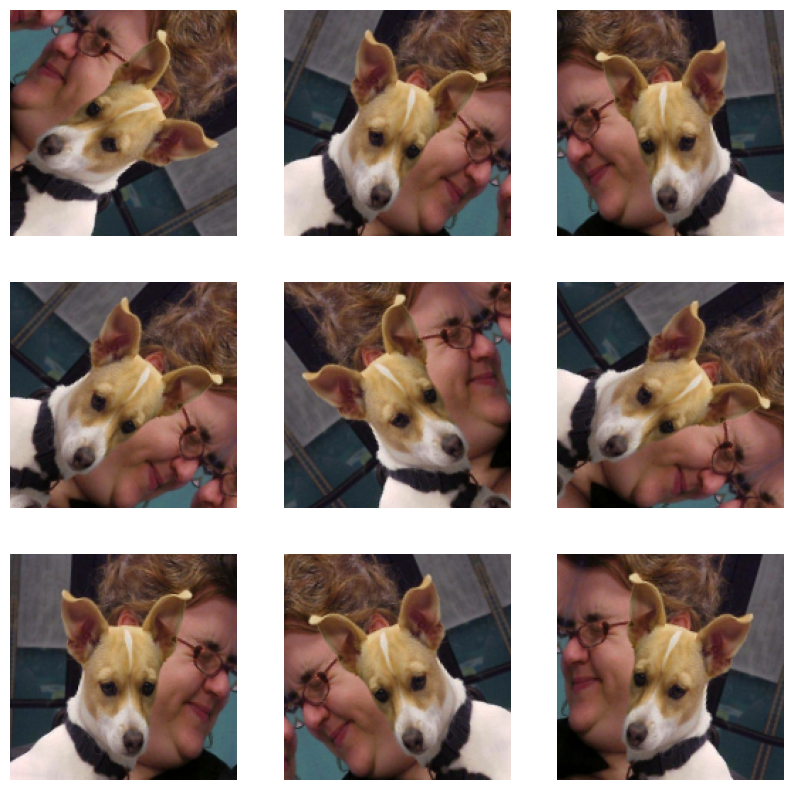

In [ ]:
plt.figure(figsize=(10,10))
for img, _ in train_dataset.take(1):
  first_img = img[0]
  for x in range(9):
    plt.subplot(3, 3, x+1)
    augmented = data_augmentation(tf.expand_dims(first_img, 0))
    plt.imshow(augmented[0] / 255)
    plt.axis("off")

***Rescale pixel values***

To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

***Create the base model from the pre-trained convnets***

Specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
img_shape = img_size + (3,)
print(img_shape)
base_model = tf.keras.applications.MobileNetV2(
    input_shape = img_shape,
    include_top=False,
    weights = "imagenet")

(160, 160, 3)
9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.

In [ ]:
img_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(img_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
label_batch.shape, img_batch.shape

(TensorShape([32]), TensorShape([32, 160, 160, 3]))

***Feature extraction***

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

***Add a classification head***

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_average = global_average_layer(feature_batch)
print(feature_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.

In [ ]:
pred_layer = tf.keras.layers.Dense(1)
pred_batch = pred_layer(feature_average)
print(pred_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers

In [ ]:
input = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(input)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = pred_layer(x)
model = tf.keras.Model(input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

***Compile the model***

In [ ]:
learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ["accuracy"])

In [ ]:
len(model.trainable_variables)

2

***Train the model***

In [ ]:
loss, accuracy = model.evaluate(val_dataset)

26/26 [==============================] - 5s 47ms/step - loss: 1.1233 - accuracy: 0.2983


In [ ]:
print("model loss: {:.2f}".format(loss))
print("model accuracy: {:.2f}".format(accuracy))

model loss: 1.12
model accuracy: 0.30


In [ ]:
history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset)

Epoch 1/10
63/63 [==============================] - 8s 64ms/step - loss: 0.4093 - accuracy: 0.7880 - val_loss: 0.1318 - val_accuracy: 0.9542
Epoch 2/10
63/63 [==============================] - 4s 58ms/step - loss: 0.1858 - accuracy: 0.9155 - val_loss: 0.0888 - val_accuracy: 0.9715
Epoch 3/10
63/63 [==============================] - 5s 67ms/step - loss: 0.1539 - accuracy: 0.9345 - val_loss: 0.0735 - val_accuracy: 0.9728
Epoch 4/10
63/63 [==============================] - 4s 56ms/step - loss: 0.1377 - accuracy: 0.9385 - val_loss: 0.0673 - val_accuracy: 0.9765
Epoch 5/10
63/63 [==============================] - 4s 62ms/step - loss: 0.1266 - accuracy: 0.9415 - val_loss: 0.0615 - val_accuracy: 0.9802
Epoch 6/10
63/63 [==============================] - 4s 62ms/step - loss: 0.1219 - accuracy: 0.9445 - val_loss: 0.0554 - val_accuracy: 0.9777
Epoch 7/10
63/63 [==============================] - 4s 55ms/step - loss: 0.1229 - accuracy: 0.9515 - val_loss: 0.0506 - val_accuracy: 0.9802
Epoch 8/10
63

****Plot Learning Curve****

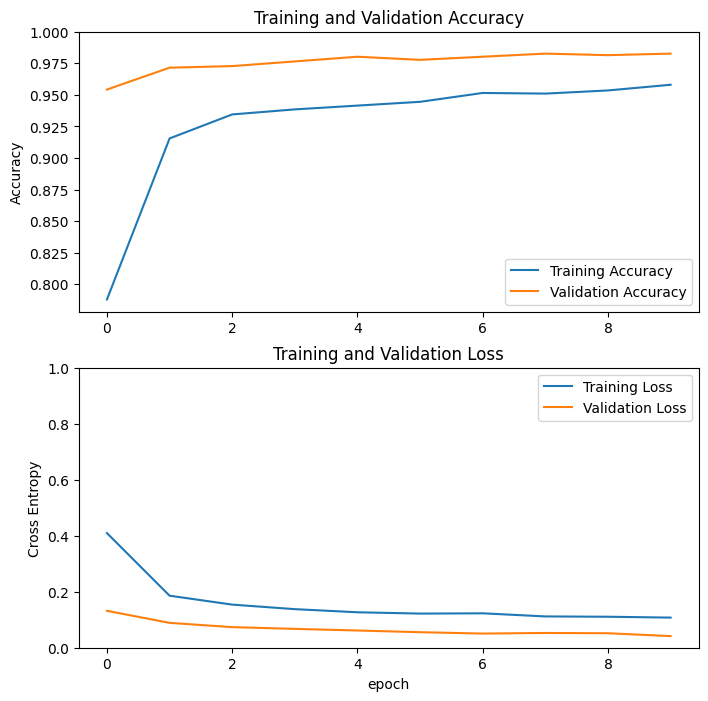

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

****Fine tuning****

**Un-freeze the top layers of the model**

In [ ]:
base_model.trainable = True

In [ ]:
print("Numbers of base model layers::", len(base_model.layers))

Numbers of base model layers:: 154


In [ ]:
fine_tune = 100
for layer in base_model.layers[:fine_tune]:
  layer.trainable = False

In [ ]:
len(base_model.layers)

154

*Compile the model*

In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate/10),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

*Training the Model*

In [ ]:
fine_tune_epochs = 20

history_fine = model.fit(train_dataset,
    epochs = fine_tune_epochs,
    initial_epoch = history.epoch[-1],
    validation_data = val_dataset)

Epoch 10/20
63/63 [==============================] - 17s 78ms/step - loss: 0.5067 - accuracy: 0.8405 - val_loss: 0.0586 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 5s 77ms/step - loss: 0.1868 - accuracy: 0.9305 - val_loss: 0.1201 - val_accuracy: 0.9641
Epoch 12/20
63/63 [==============================] - 4s 62ms/step - loss: 0.1715 - accuracy: 0.9335 - val_loss: 0.0535 - val_accuracy: 0.9777
Epoch 13/20
63/63 [==============================] - 5s 70ms/step - loss: 0.1451 - accuracy: 0.9395 - val_loss: 0.0823 - val_accuracy: 0.9703
Epoch 14/20
63/63 [==============================] - 5s 80ms/step - loss: 0.1032 - accuracy: 0.9560 - val_loss: 0.0576 - val_accuracy: 0.9728
Epoch 15/20
63/63 [==============================] - 5s 76ms/step - loss: 0.1195 - accuracy: 0.9530 - val_loss: 0.2234 - val_accuracy: 0.9344
Epoch 16/20
63/63 [==============================] - 6s 84ms/step - loss: 0.1259 - accuracy: 0.9540 - val_loss: 0.0442 - val_accuracy: 0.9864
Epoch

**Plot Learning Curve**

In [ ]:
initial_epochs = 10

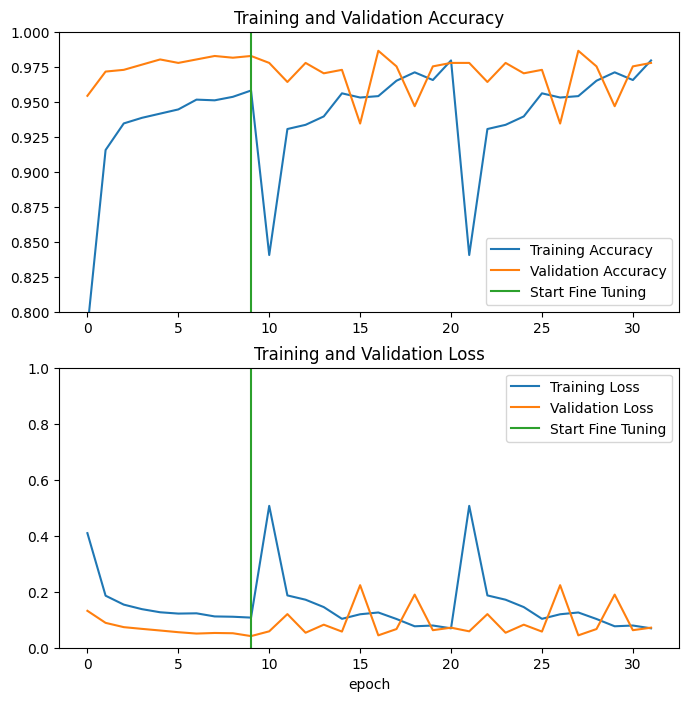

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

***Evaluation and prediction***

In [ ]:
loss1, accuracy1 = model.evaluate(test_dataset)

6/6 [==============================] - 1s 41ms/step - loss: 0.0344 - accuracy: 0.9844


prediction :: 
 [0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0]
labels :: 
 [0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0]


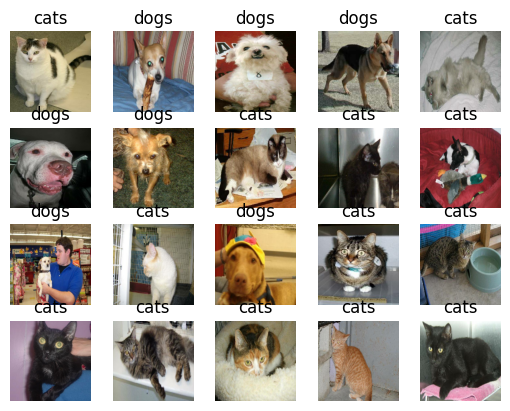

In [ ]:
img_batch, label_batch = test_dataset.as_numpy_iterator().next()
pred = model.predict_on_batch(img_batch).flatten()
pred = tf.nn.sigmoid(pred)
pred = tf.where(pred < 0.5, 0, 1)
print("prediction :: \n", pred.numpy())
print("labels :: \n", label_batch)
#plt.figure(figsize=(10,30))
for x in range(20):
  plt.subplot(4, 5, x+1)
  plt.imshow(img_batch[x].astype("uint8"))
  plt.title(classes[pred[x]])
  plt.axis("off")